## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [61]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report


In [12]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


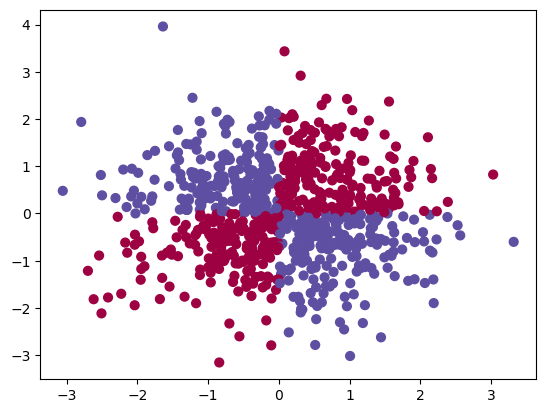

In [14]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [27]:
import abc
class Module:
    # requiring inheriting classes to implement abstract methods
    __metaclass__ = abc.ABCMeta

    def __init__(self, name):
        self.name = name
        self.weights = {}
        self.grad_weights = {}
    
    @abc.abstractmethod
    def forward(self, input):
        pass

    @abc.abstractmethod
    def backward(self, grad_output):
        pass

    def __repr__(self):
        return self.name

In [29]:
class Composition(Module): 
    def __init__(self, submodules):
        self.submodules = submodules
        self.name = f'Composition({", ".join(submodule.name for submodule in submodules)})'
        self.weights = {
            f'{submodule.name}.{weight_name}': weight
            for submodule in self.submodules
            for weight_name, weight in submodule.weights.items()
        }
    def forward(self, input):
        for submodule in self.submodules:
            input = submodule.forward(input)
        self.output = input
        return input
    def backward(self, grad_output):
        for submodule in reversed(self.submodules):
            # value of submodule.backward is the grad_output for the next submodule
            grad_output = submodule.backward(grad_output)
        #collect all grad_weights together
        self.grad_weights = {
            f'{submodule.name}.{weight_name}':grad_weight
            for submodule in self.submodules
            for weight_name, grad_weight in submodule.grad_weights.items()
        }
        return grad_output


In [30]:
class SGD:
    def __init__(self, module, lr = 1e-3):
        self.module = module
        self.lr = lr
    def step(self):
        for weight_name, weight in self.module.weights.items():
            weight -= self.lr * self.module.grad_weights[weight_name]

In [31]:
class MSE(Module):
    def __init__(self):
        super().__init__('MSE')
    def forward(self, input_y, input_t):
        self.input_y = input_y
        self.input_t = input_t
        return np.mean((input_y - input_t)**2)
    def backward(self):
        return 2 * (self.input_y - self.input_t) / len(self.input_t)

In [32]:
class Linear(Module):
    def __init__(self, n_in_features, n_out_features):
        super().__init__(f'Linear({n_in_features, n_out_features})')
        self.n_in_features = n_in_features
        self.n_out_features = n_out_features

        #initialize weights so that they are unfirmly in the unit ball
        #don't worry about this choice

        stdv = 1.0/np.sqrt(self.n_in_features)
        sample_unit_ball = lambda size: np.random.uniform(-stdv, stdv, size)
        self.weights = {
            'W': sample_unit_ball((n_out_features, n_in_features)),
            'b': sample_unit_ball((n_out_features, ))
        }
    
    def forward(self, input):
        self.input = input # this is our x
        return input @ self.weights['W'].T + self.weights['b']
    
    def backward(self, grad_output):
        self.grad_weights = {
            'W': grad_output.T @ self.input, # this is our gradient
            'b': grad_output.T @ np.ones((len(self.input), )) # this second term is our gradient
        }
        #return the grad_input
        grad_linear = self.weights['W']
        return grad_output @ grad_linear

                                    

In [68]:
class Softmax(Module):
    def __init__(self, n_classes):
        super().__init__(f'Softmax({n_classes})')
        self.n_classes = n_classes
    
    def forward(self, input):
        p = np.exp(input)
        sums = np.sum(p, axis=1)
        self.output = (p.T/sums.T).T
        return self.output
    def backward(self, grad_output):
        s = self.output
        diag = np.einsum('ij, jk -> ijk', s, np.identity(s.shape[1]))
        outer = np.einsum('ij, ik -> ijk', s, s)
        grad_softmax = diag - outer
        return np.einsum('ijk, ik -> ij', grad_softmax, grad_output)


class ReLu(Module):
    def __init__(self):
        super().__init__('ReLu')
    def forward(self, input):
        self.input = input
        return input * (input > 0)
    
    def backward(self, grad_output):
        grad_relu = (self.input > 0)
        return grad_output * grad_relu


In [66]:
class SoftmaxCrossEntropy(Module):
    def __init__(self, n_classes):
        super().__init__(f'CrossEntropy({n_classes})')
        self.n_classes = n_classes
        self.softmax = Softmax(n_classes)
    
    def forward(self, input, t):
        self.t = t
        self.softmax_output = self.softmax.forward(input)
        return -np.mean(t*np.log(self.softmax_output + 1e-6))
    
    def backward(self):
        return (self.softmax_output - self.t)/len(self.t)

In [87]:
def one_hot_encode(y, n_classes):
    return np.identity(n_classes)[y.astype(int)]

def generate_data(dataset_name, n_samples=100):
    match dataset_name:
        case 'regression: an affine line':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = 3 * X - 100
        case 'regression: cubic polynomial':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = X ** 3 - 2 * X + 5
        case 'classification: linearly separable':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] > X[:, 1] + 1).astype(int), 2)
        case 'classification: XOR':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] * X[:, 1] > 0).astype(int), 2)
        case _:
            raise ValueError('invalid dataset name')
    return X, y


def train_and_test(model, loss_fn, optimizer, dataset_name, n_epochs=5000, n_samples=100):
    # train
    X_train, y_train = generate_data(dataset_name, n_samples=n_samples)
    losses = []
    for _ in tqdm(range(n_epochs)):
        output = model.forward(X_train)
        loss = loss_fn.forward(output, y_train) 
        losses.append(loss)
        model.backward(loss_fn.backward())
        optimizer.step()
    
    # test and plot
    X_test, y_test = generate_data(dataset_name, n_samples=n_samples)

    fig, ax = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    ax[0].set_title('loss during training')
    ax[1].set_title('predictions and truth')
    if dataset_name.startswith('classification'):
        y_pred = np.argmax(model.forward(X_test), axis=1)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=np.argmax(y_test, axis=1), ax=ax[1])
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, s=100, alpha=0.2, ax=ax[1])
        plt.legend([],[], frameon=False)
    elif dataset_name.startswith('regression'):
        y_pred = model.forward(X_test)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(x=X_test[:, 0], y=y_test[:, 0], ax=ax[1])
        sns.scatterplot(x=X_test[:, 0], y=y_pred[:, 0], s=100, alpha=0.2, ax=ax[1])
        plt.legend([],[], frameon=False)


100%|██████████| 5000/5000 [00:02<00:00, 2462.19it/s]


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      97.0
           1       0.00      0.00      0.00     103.0

    accuracy                           0.00     200.0
   macro avg       0.00      0.00      0.00     200.0
weighted avg       0.00      0.00      0.00     200.0



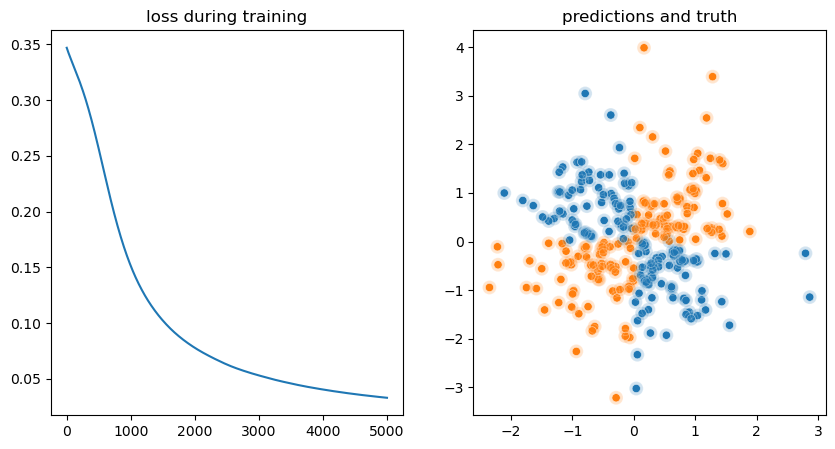

In [91]:
H = 32

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=250
)


100%|██████████| 5000/5000 [00:01<00:00, 4179.78it/s]


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      97.0
           1       0.00      0.00      0.00     103.0

    accuracy                           0.00     200.0
   macro avg       0.00      0.00      0.00     200.0
weighted avg       0.00      0.00      0.00     200.0



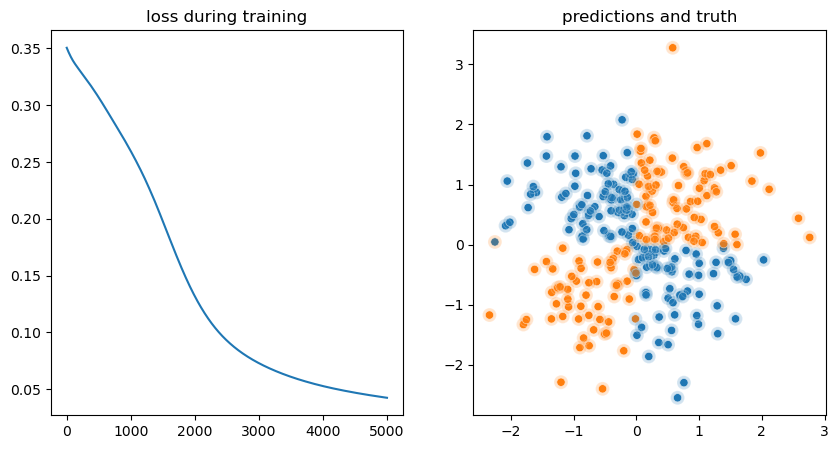

In [92]:
#Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc)
# lowered number of hidden layers to 15
#
H = 15

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=250
)

100%|██████████| 5000/5000 [00:00<00:00, 7478.13it/s]


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.30      0.20      0.24        97
           1       0.43      0.56      0.49       103

    accuracy                           0.38       200
   macro avg       0.36      0.38      0.36       200
weighted avg       0.36      0.39      0.36       200



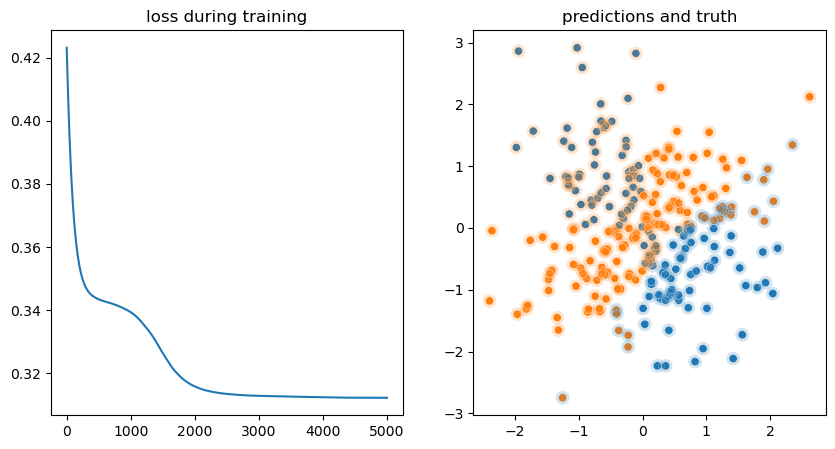

In [93]:
# lowerd hidden layers to 1
# the loss isn't as low as with a higher number of layers and it struggles to capture complex patterns/relationships
H = 1

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=250
)


100%|██████████| 5000/5000 [00:07<00:00, 632.02it/s]


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.03      0.03      0.03        97
           1       0.01      0.01      0.01       103

    accuracy                           0.02       200
   macro avg       0.02      0.02      0.02       200
weighted avg       0.02      0.02      0.02       200



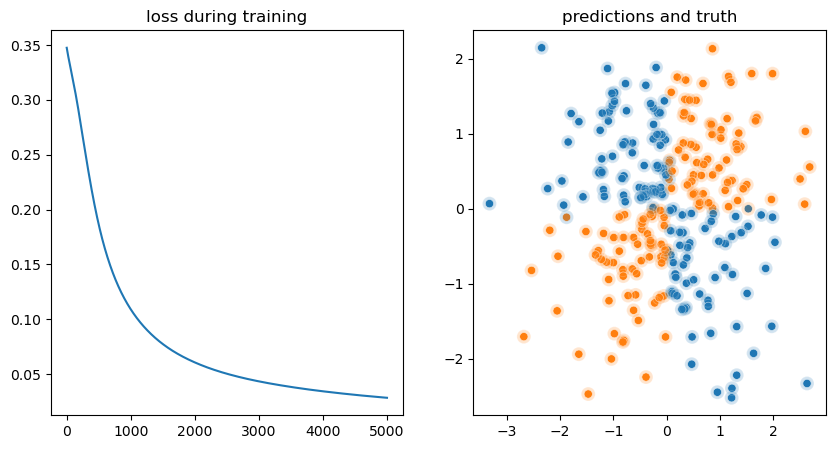

In [94]:
# increasing number of hidden layers does not seem to improve model accruacy in this case
H = 100

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=250
)

100%|██████████| 50/50 [00:00<00:00, 2267.68it/s]


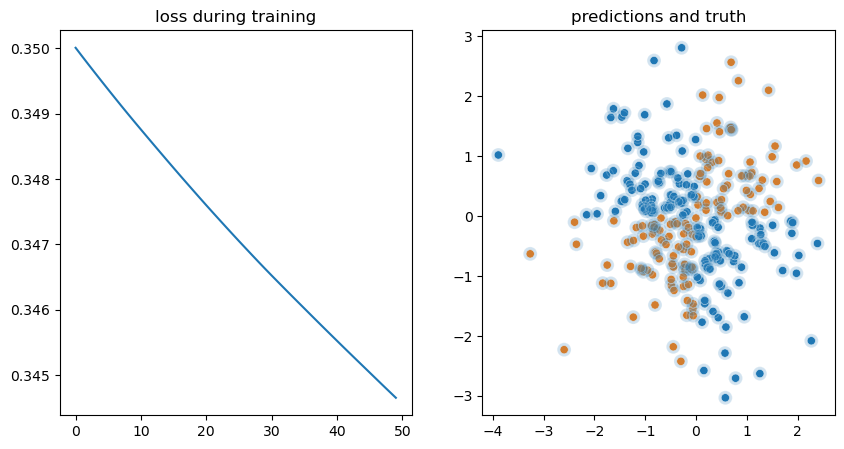

In [78]:
# decreased number of epochs to 50
# here the loss is higher during training and the accuracy is lower
H = 32

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=50,
    n_samples=250
)

100%|██████████| 50000/50000 [00:21<00:00, 2367.09it/s]


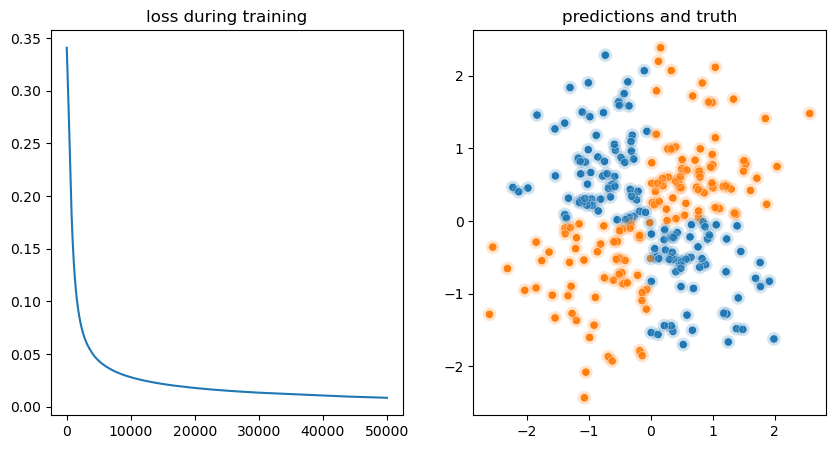

In [79]:
# increasing the epoch lower the loss by a lot but didn't really improve accuracy too much
# a higher epoch could lead to overfitting
H = 32

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=50000,
    n_samples=250
)

100%|██████████| 5000/5000 [00:00<00:00, 7174.50it/s]


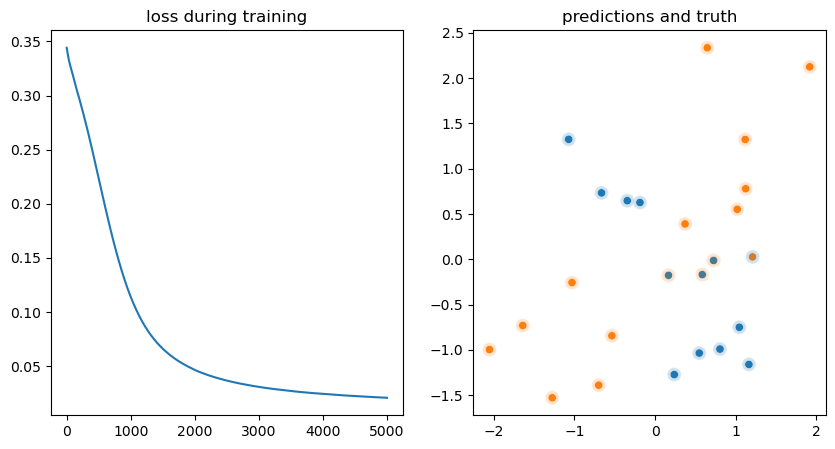

In [80]:
# a low number of samples made the model accuracy poor
H = 32

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=25
)

100%|██████████| 5000/5000 [00:17<00:00, 291.88it/s]


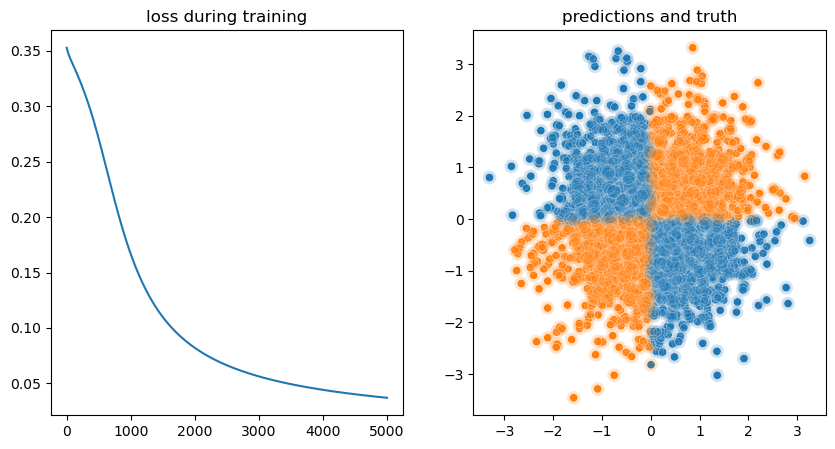

In [81]:
# more samples lead to better decision boundaries, it generalizes patterns better
H = 32

model = Composition([
    Linear(2, H),
    ReLu(),
    Linear(H, H),
    ReLu(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=2500
)